In [1]:
import distutils.spawn
import os
from matplotlib import rc
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import torch

sns.set(font_scale=1.5)
if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)

In [2]:
def sigma(x):
    """Activation function."""
    z = torch.zeros_like(x)
    return torch.minimum(torch.maximum((4*(x+0.5)**3), z), z+0.5) \
        + torch.minimum(torch.maximum((0.5 - 4*(0.5-x)**3), z), z+0.5)

In [3]:
class mynn(torch.nn.Module):
    def __init__(self, a, u, eta):
        super(mynn, self).__init__()
        self.a = torch.nn.Parameter(a)
        self.u = torch.nn.Parameter(u)
        self.eta = eta
        self.sigma = lambda x: sigma(x / self.eta)

    def forward(self, x):
        return torch.sum(self.a[..., None] * self.sigma(x - self.u[..., None]), dim = (0, 1))

In [4]:
def target(x):
    return (x[0] > 0.3).double() + (x[1] > 0.3).double() \
    + (x[0] > 0.5).double() + (x[1] > 0.5).double() \
    + (x[0] > 0.7).double() + (x[1] > 0.7).double()

In [5]:
n_repeats = 20
n = 10**3
n_epoch = 150
filepath = 'rebuttal/2d-standard.pkl'

metrics = {'loss': [], 'u': [], 'a': []}
for k in range(n_repeats):
    print(k)
    x = torch.rand(2, n)
    u = torch.rand(10, 2)
    a = 3 * torch.rand(10, 2)
    model = mynn(a, u, 0.01)
    optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        y_pred = model(x)
        y_target = target(x)
        criterion = torch.norm(y_pred - y_target) / n
        criterion.backward()
        optimizer.step()
    metrics['loss'].append(float(criterion))
    metrics['u'].append(model.u.detach().numpy())
    metrics['a'].append(model.a.detach().numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [6]:
with open(filepath, 'wb') as file:
    pickle.dump(metrics, file)

In [20]:
def plot_solution(u, filepath):
    plt.figure(figsize=(5,5))
    xmax = max(max(u[:, 0]), 1.0)
    ymax = max(max(u[:, 1]), 1.0)
    plt.hlines([0., 1.0],
        xmin=0.,
        xmax=1.0,
        color='black',
        linestyle='dotted')
    plt.hlines([0.3, 0.5, 0.7],
        xmin=0.,
        xmax=1.0,
        color='C{}'.format(0),
        label='Target')
    plt.hlines(u[:, 1],
        xmin=0.,
        xmax=xmax,
        color='C{}'.format(1),
        linestyle='--',
        alpha=1.0,
        label='Neurons')
    plt.vlines([0., 1.0],
        ymin=0.,
        ymax=1.0,
        color='black',
        linestyle='dotted')
    plt.vlines([0.3, 0.5, 0.7],
        ymin=0.,
        ymax=1.0,
        color='C{}'.format(0))
    plt.vlines(u[:, 0],
        ymin=0.,
        ymax=ymax,
        color='C{}'.format(1),
        linestyle='--',
        alpha=1.0)
    Xs = [0., 0.3, 0.5, 0.7, 1.0]
    Ys = [0., 0.3, 0.5, 0.7, 1.0]
    plt.xticks(Xs)
    plt.yticks(Ys)
    for i in range(4):
        for j in range(4):
            alpha = 0.2 + 0.79 * (i+j) / 6
            plt.fill([Xs[i], Xs[i+1], Xs[i+1], Xs[i]], [Ys[j], Ys[j], Ys[j+1], Ys[j+1]], 'C0', alpha=alpha)
    plt.legend(**{'loc': 'lower left', 'bbox_to_anchor': (-0.6, 0.32)})
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()

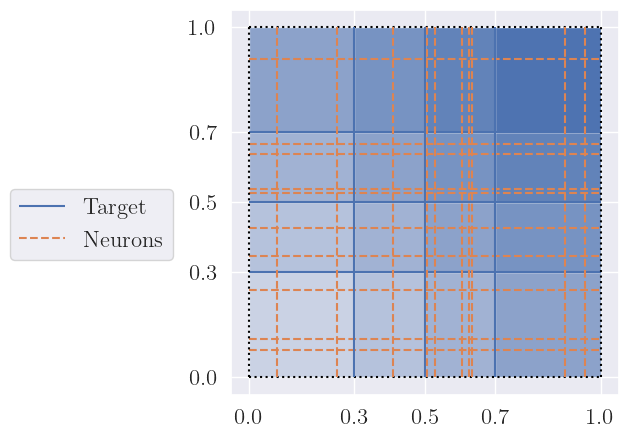

In [21]:
plot_solution(torch.rand(10, 2), 'rebuttal/plot_solution_2d_init.png')

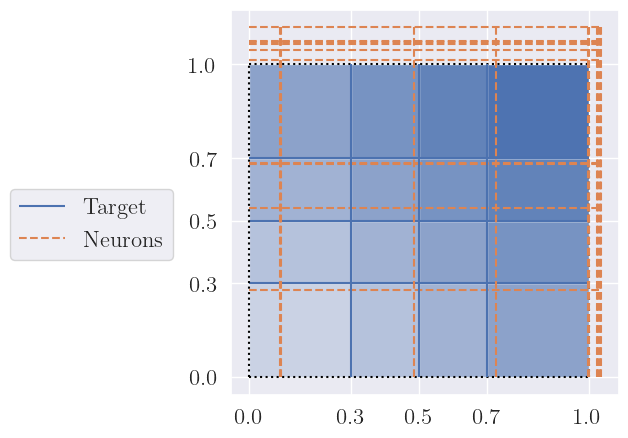

In [13]:
plot_solution(metrics['u'][0], 'rebuttal/plot_solution_2d_standard.png')

In [9]:
n_repeats = 20
n = 10**3
n_epoch = 5*10**3
filepath = 'rebuttal/2d-fs.pkl'

metrics_fs = {'loss': [], 'u': [], 'a': []}
for k in range(n_repeats):
    print(k)
    x = torch.rand(2, n)
    u = torch.rand(10, 2)
    a = 3 * torch.rand(10, 2)
    model = mynn(a, u, 0.01)
    optimizer_a = torch.optim.SGD([model.a], lr=1.0)
    optimizer_u = torch.optim.SGD([model.u], lr=0.01)
    for epoch in range(n_epoch):
        optimizer_a.zero_grad()
        optimizer_u.zero_grad()
        y_pred = model(x)
        y_target = target(x)
        criterion = torch.norm(y_pred - y_target) / n
        criterion.backward()
        optimizer_a.step()
        optimizer_u.step()
    metrics_fs['loss'].append(float(criterion))
    metrics_fs['u'].append(model.u.detach().numpy())
    metrics_fs['a'].append(model.a.detach().numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [10]:
with open(filepath, 'wb') as file:
    pickle.dump(metrics_fs, file)

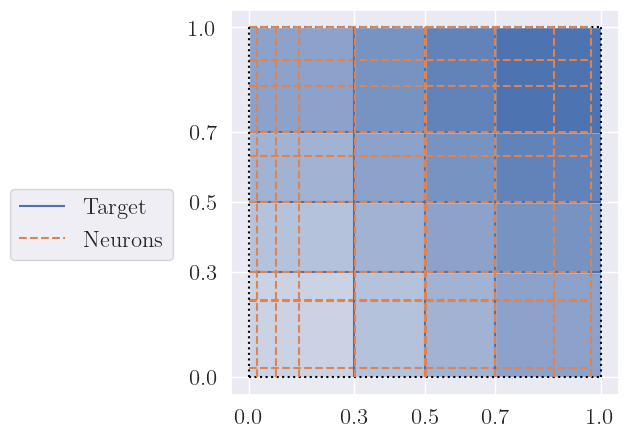

In [11]:
plot_solution(metrics_fs['u'][0], 'rebuttal/plot_solution_2d_fs.png')

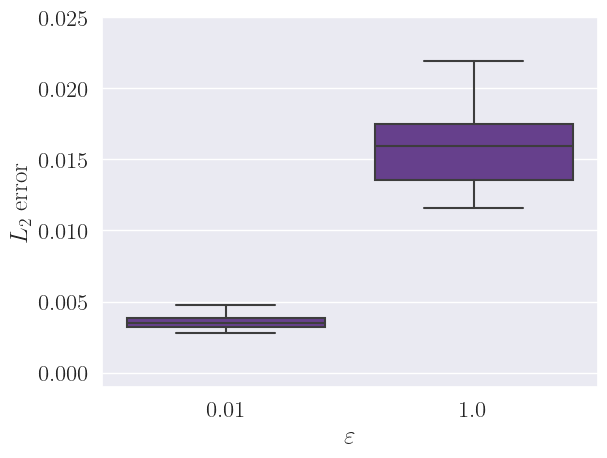

In [17]:
d = {r'$\varepsilon$': [1.0]*20 + [0.01]*20, r'$L_2$ error': metrics['loss'] + metrics_fs['loss']}
df = pd.DataFrame.from_dict(d)
sns.boxplot(data=df, x=r'$\varepsilon$', y=r'$L_2$ error', color='rebeccapurple')
#plt.yscale('log')
plt.ylim([-0.001, 0.025])
plt.savefig('rebuttal/plot_error_2d.png', dpi=150, bbox_inches='tight')
plt.show()